# Modeling Financial Risk in <del>  R  </del> Python
### 2nd Lab

In [146]:
import pandas as pd
import numpy as np 
import quandl
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 6)

25 październik

In [147]:
df = pd.read_excel("C:/Users/anton/Documents/data/SGH/UNIQA_Akcje_Rynkow_Wschodzacych.xlsx")

In [148]:
df

,UNIQA Akcji Rynków Wschodzących (d. Akcji Spółek Dywidendowych),Od: 11-03-2014,Do: 04-11-2023
0,Data:,Wartość:,NaN
1,11-03-2014,100,NaN
2,12-03-2014,99.99,NaN
3,13-03-2014,99.99,NaN
4,14-03-2014,99.99,NaN
...,...,...,...
2411,26-10-2023,83.49,NaN
2412,27-10-2023,83.77,NaN
2413,30-10-2023,84.07,NaN
2414,31-10-2023,83.67,NaN


We should wrangle the data through the function for the further anaylysis (one-off operation)

In [149]:
def wrangle(df, rolling_window):
    df = df.copy()

    df.columns = df.iloc[0]
    df = df.iloc[1:,:2]
    df = df.rename(columns={'Data:': 'Date', 'Wartość:': 'Close'})
    df.reset_index(drop=True, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
    df.set_index('Date', inplace=True)

    df["Close"] = pd.to_numeric(df["Close"])
    #Simple return
    df['pct_return'] = (df["Close"] / df["Close"].shift(1) - 1)
    #Log return - thats what we want
    df['log_return'] = np.log(df["Close"] / df["Close"].shift(1))

    #Rolling std
    df["rolling_std"] = df["log_return"].rolling(rolling_window).std() * np.sqrt(252)

    #Deleting NaN
    df.dropna(inplace = True)
    df = df.sort_index(ascending=False)
    return df#round(df, 4)


In [150]:
df_working = wrangle(df, 22)

In [151]:
df_working.head()

,Close,pct_return,log_return,rolling_std
Date,,,,
2023-11-02,85.55,0.022469,0.022221,0.151867
2023-10-31,83.67,-0.004758,-0.004769,0.128760
2023-10-30,84.07,0.003581,0.003575,0.132665
2023-10-27,83.77,0.003354,0.003348,0.131732
2023-10-26,83.49,-0.009374,-0.009418,0.130890


Now, the anlysis setup is supposed to be 1250 trading days back 25th October

In [176]:
df = df_working[df_working.index < "2023-10-26"]
df = df.iloc[:1250,:]
df.head()

,Close,pct_return,log_return,rolling_std
Date,,,,
2023-10-25,84.28,-0.009053,-0.009095,0.131965
2023-10-24,85.05,0.014311,0.014210,0.129997
2023-10-23,83.85,-0.004630,-0.004640,0.124371
2023-10-20,84.24,-0.009291,-0.009334,0.138113
2023-10-19,85.03,-0.009552,-0.009597,0.136752


In [180]:
#Save
df.to_csv("C:/Users/anton/Documents/data/SGH/UNIQA_Akcje_clean.csv")

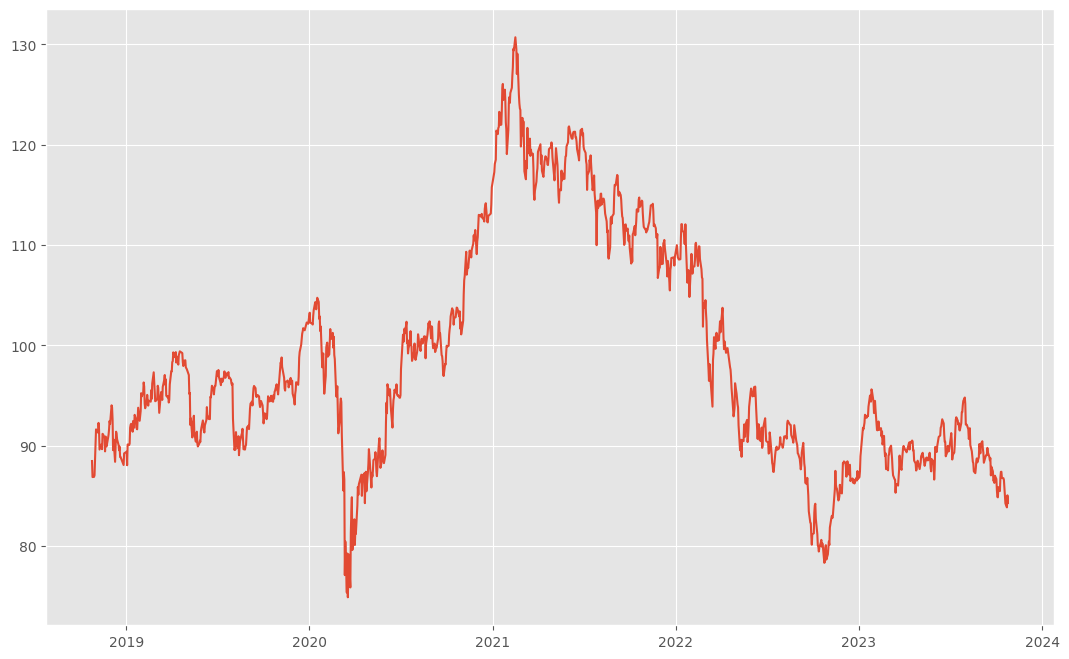

In [181]:
# Let's have a look at the time series on log plot
plt.figure(figsize = (13,8))
plt.plot(df.index, df["Close"]);

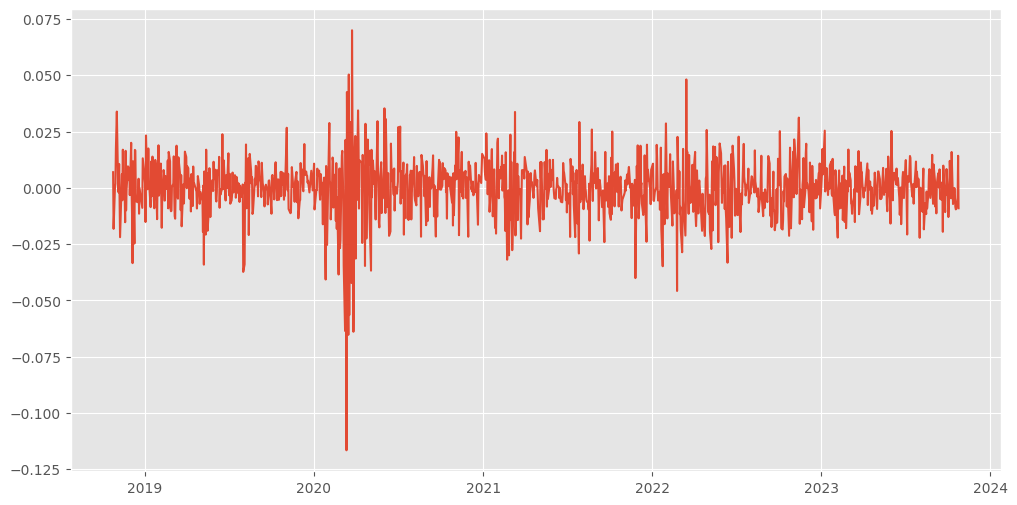

In [182]:
plt.plot(df["log_return"]);

### Statistics

In [183]:
#min = np.min(y)
#max = np.max(y)
mean = np.mean(df["log_return"])
mean_annualized = mean* 252
variance = np.var(df["log_return"])
std = np.std(df["log_return"], ddof=1)
std_annualized = std * np.sqrt(252)
skew = stats.skew(df["log_return"])
kurtosis = stats.kurtosis(df["log_return"])
jq = stats.jarque_bera(df["log_return"])

print(f"Mean is {mean}\nVariance is {variance}\nStandard deviation is {std}\nSkew is {skew}\nKurtosis is {kurtosis}\nJarque-Bera test statistics = {round(jq[0],4)} and p-value = {jq[1]}")
print(f"\n\nAnnualized mean is {round(mean_annualized,4)}\nAnnualized std is {round(std_annualized,4)}")

Mean is -3.328003968931732e-05
Variance is 0.0001544555221689167
Standard deviation is 0.012432987795269912
Skew is -0.9832999622800712
Kurtosis is 9.205899931493384
Jarque-Bera test statistics = 4615.4223 and p-value = 0.0


Annualized mean is -0.0084
Annualized std is 0.1974


In [185]:
from scipy.stats import normaltest
import statsmodels.api as sm

In [187]:
# D'Agostiono test
statistic, p_value = normaltest(df["log_return"])
print(f"D'Agostino test:\nStatistic = {round(statistic,4)}, p-value = {round(p_value,4)}")

# JB Test
test_statistic, p_value_jb, skewness, kurt = sm.stats.jarque_bera(df["log_return"])
print(f"\nJB test:\nTest statistic = {round(test_statistic,4)}\np-value = {round(p_value_jb,4)}")
print(f"Estimated skewness = {round(skewness,4)}\nEstimated kurtosis = {round(kurt,4)}")

D'Agostino test:
Statistic = 365.4083, p-value = 0.0

JB test:
Test statistic = 4615.4223
p-value = 0.0
Estimated skewness = -0.9833
Estimated kurtosis = 12.2059


## Fitting the cruves - shape of the distribution

In [188]:
from scipy.optimize import curve_fit
from distfit import distfit

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.0 sec] [RSS: 737.304] [loc=-0.000 scale=0.012]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 11049.7] [loc=-0.117 scale=0.117]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 11049.7] [loc=-8388608.117 scale=8388608.000]
[distfit] >INFO> [dweibull  ] [0.01 sec] [RSS: 175.712] [loc=-0.000 scale=0.009]
[distfit] >INFO> [t         ] [0.11 sec] [RSS: 140.191] [loc=0.000 scale=0.009]
[distfit] >INFO> [genextreme] [0.12 sec] [RSS: 12289.4] [loc=0.001 scale=0.095]
[distfit] >INFO> [gamma     ] [0.04 sec] [RSS: 11749.2] [loc=-0.117 scale=1.129]
[distfit] >INFO> [lognorm   ] [0.02 sec] [RSS: 928.02] [loc=-0.257 scale=0.256]
[distfit] >INFO> [beta      ] [0.13 sec] [RSS: 697.275] [loc=-12114.132 scale=12114.260]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 9710.08] [loc=-0.117 scale=0.187]
[distfit] >INFO> [loggamma  ] [0.01 sec] [RSS: 650.73] [loc=-0.160 scale=0.054]


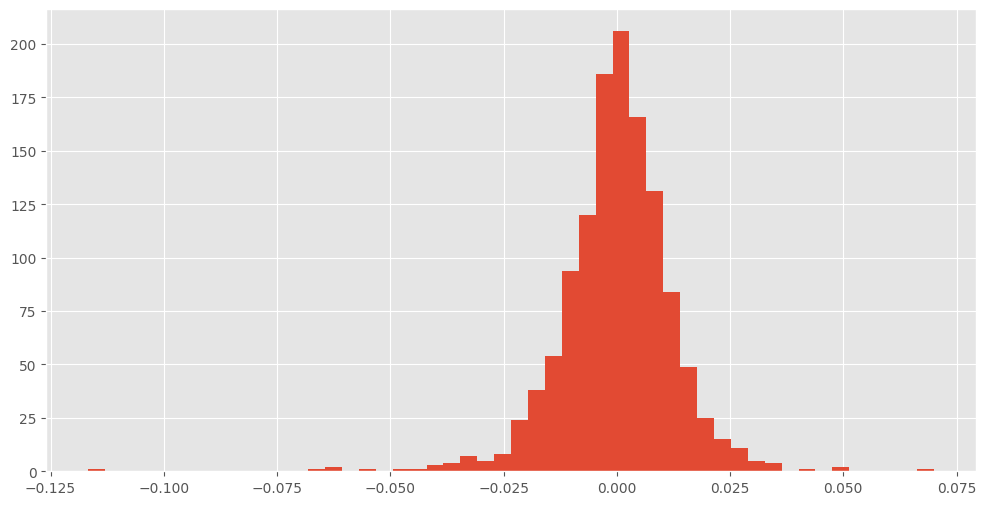

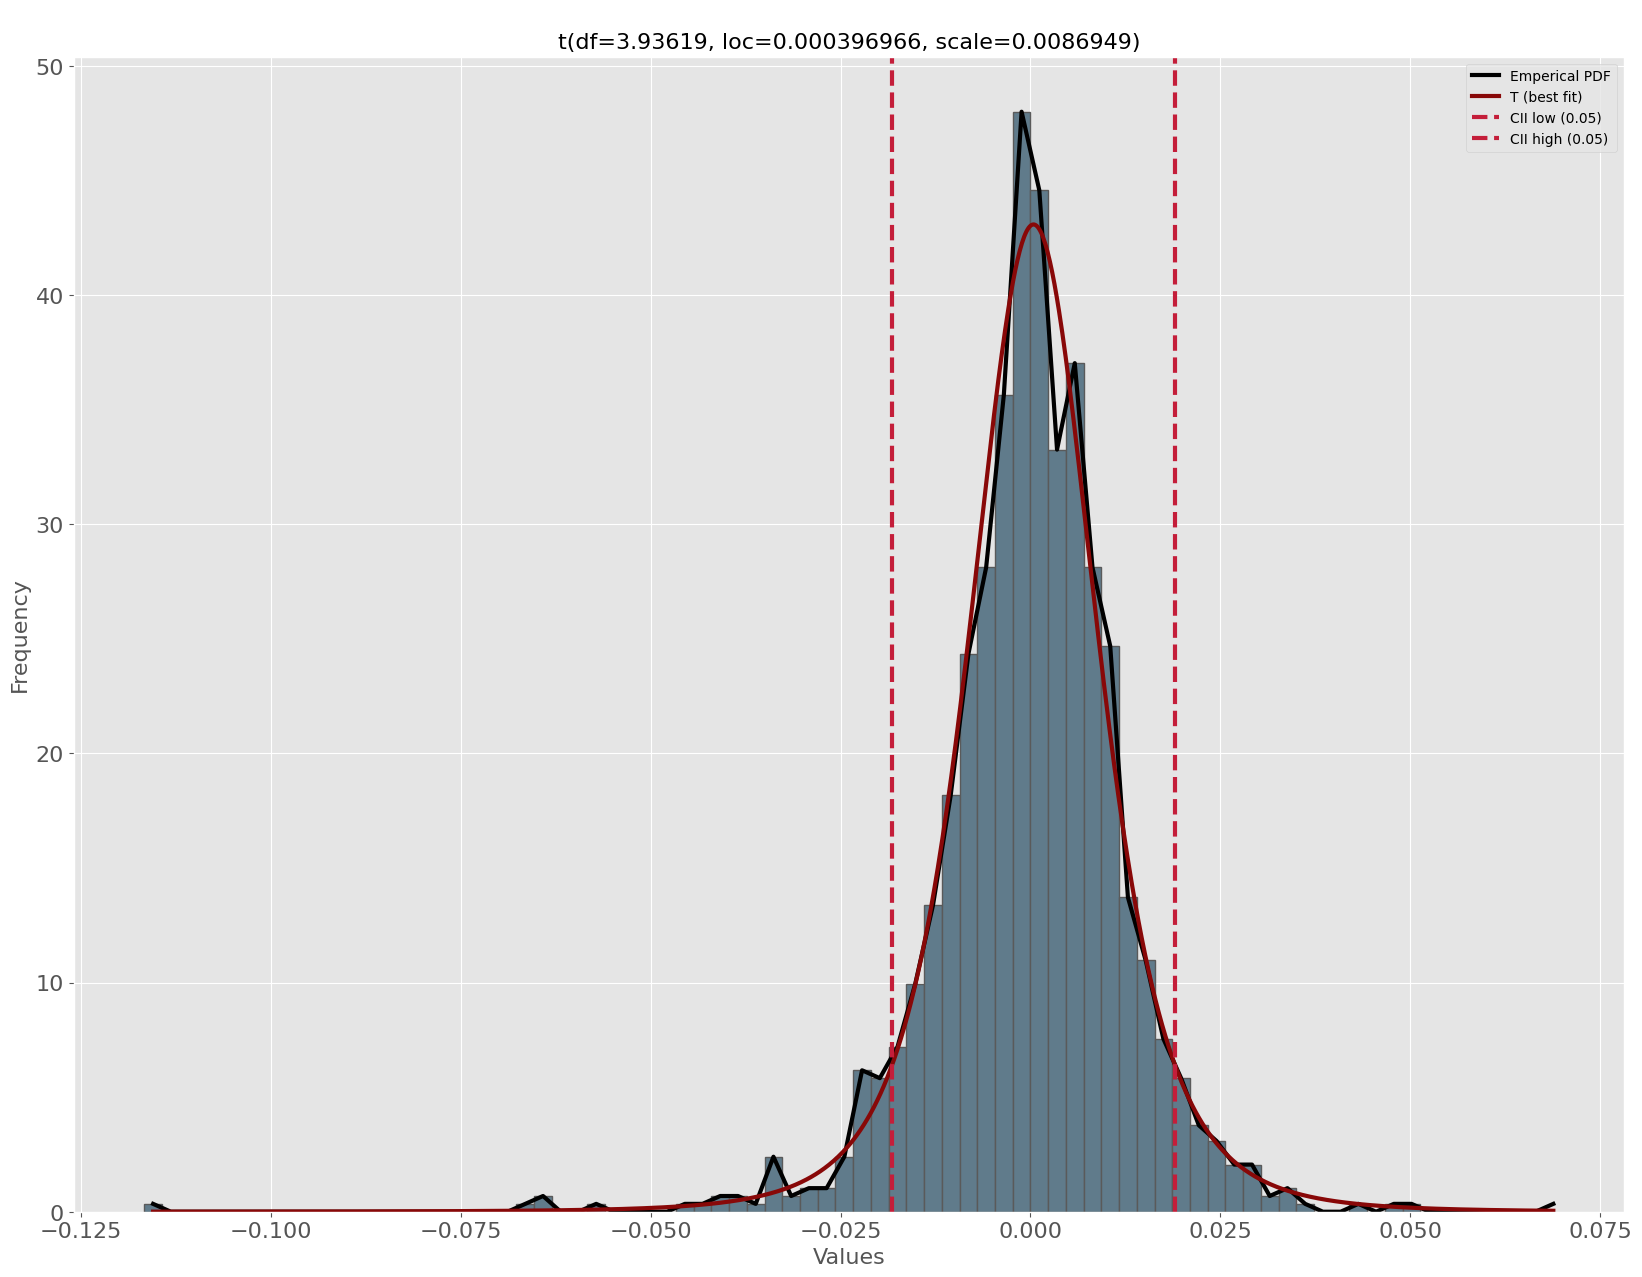

In [189]:
plt.hist(df["log_return"], bins = 50);

dist = distfit()
dist.fit_transform(df["log_return"])
dist.plot();

In [190]:
print(dist.summary)

          name         score             loc         scale  \
0            t    140.190948        0.000397      0.008695   
1     dweibull     175.71152       -0.000027      0.008908   
2     loggamma    650.729786        -0.15984       0.05394   
3         beta    697.274926   -12114.131894  12114.259852   
4         norm    737.303668       -0.000033      0.012428   
5      lognorm    928.019812       -0.256717      0.256363   
6      uniform   9710.083301       -0.116658      0.186644   
7        expon  11049.671161       -0.116658      0.116625   
8       pareto  11049.671173 -8388608.116658     8388608.0   
9        gamma  11749.205821       -0.116658      1.129472   
10  genextreme  12289.424923        0.001254      0.094526   

                                         arg  \
0                      (3.9361930049697147,)   
1                      (1.0509276248337804,)   
2                      (19.846984658954867,)   
3   (10104981.902737385, 106.76948538928775)   
4              

#### As we can seee, the best fit is for the t-distribution

### QQ plot

In [191]:
from statsmodels.graphics.gofplots import qqplot

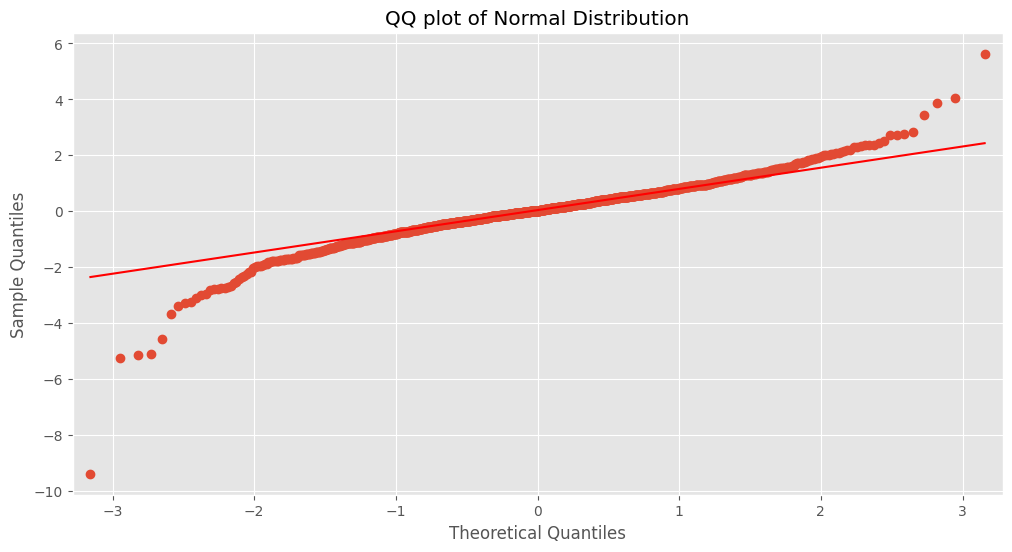

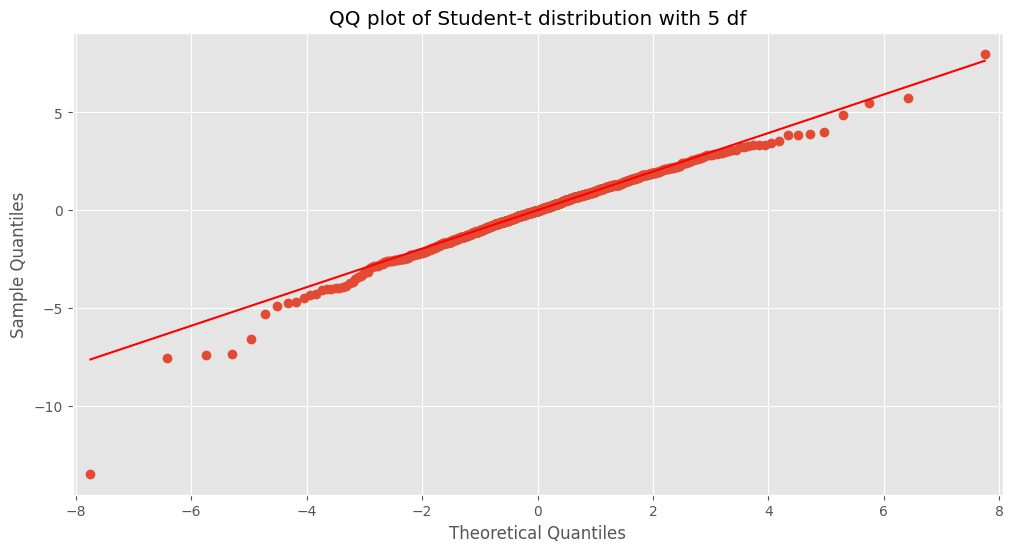

In [192]:
fig1 = qqplot(df["log_return"], line='q', dist = stats.norm, fit = True)               
plt.title("QQ plot of Normal Distribution")
plt.show()
plt.close()

fig2 = qqplot(df["log_return"], line='q', dist = stats.t, distargs=(5,), fit = True)
plt.title("QQ plot of Student-t distribution with 5 df")
plt.show()
plt.close()

### Autocorrelation

In [196]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

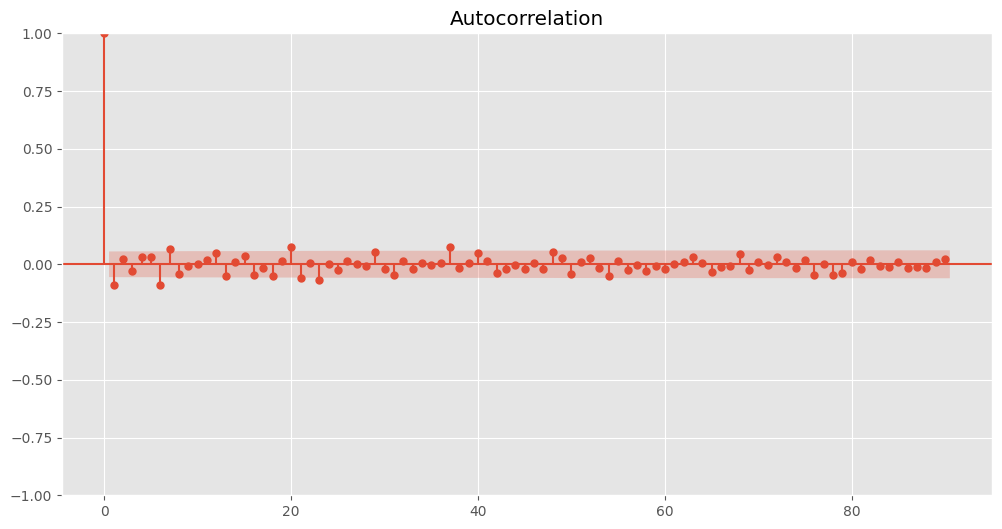

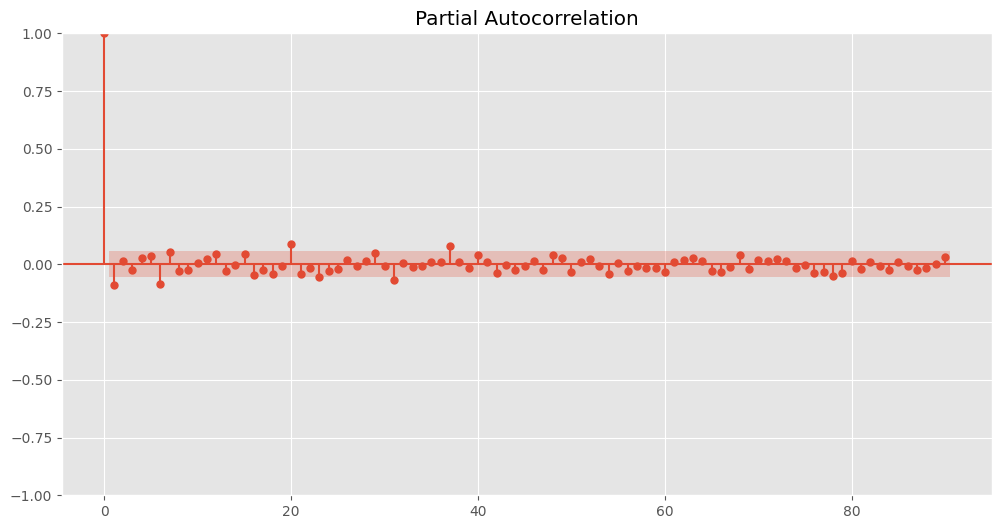

In [197]:
# Autocorrelation for log_returns
plot_acf(df["log_return"], lags=90);
plot_pacf(df["log_return"], lags=90);

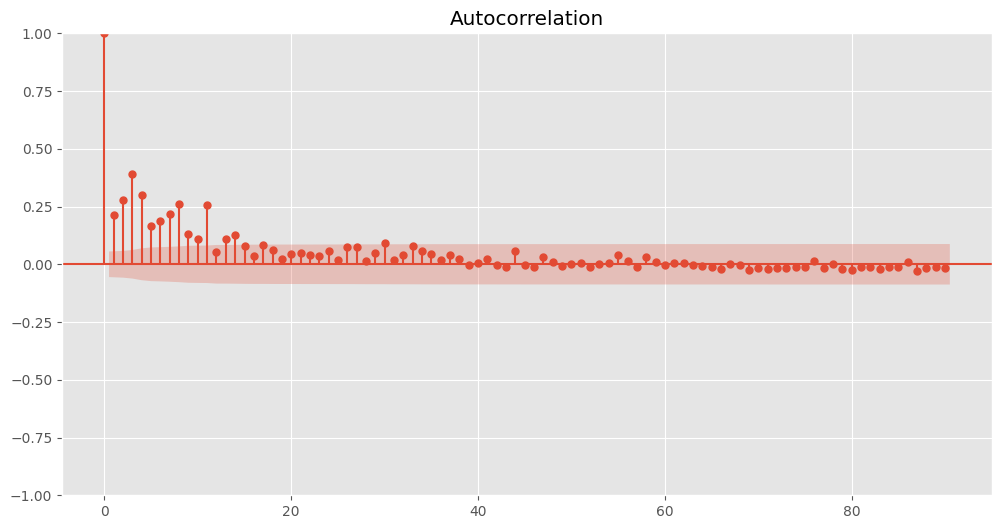

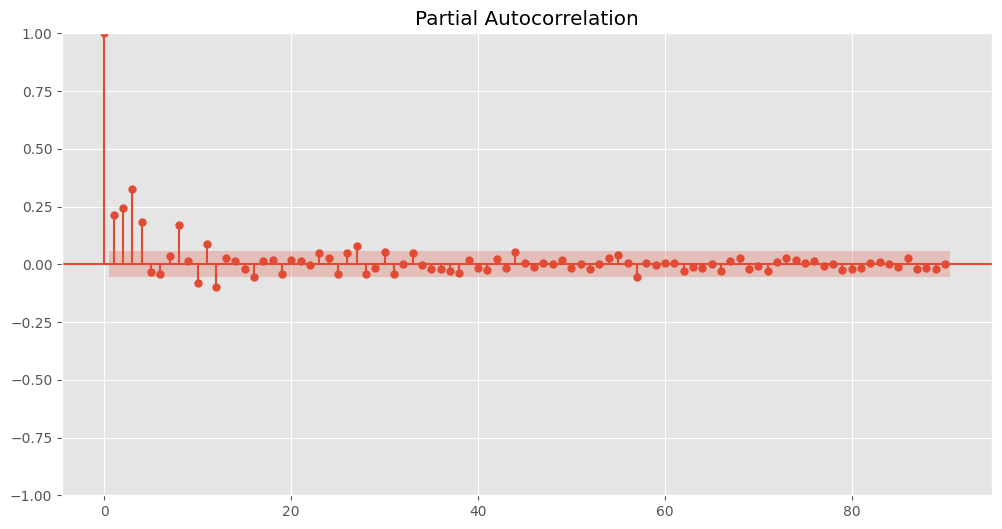

In [198]:
# Autocorrelation for squared returns
plot_acf(df["log_return"] **2 , lags=90);
plot_pacf(df["log_return"] **2, lags=90);